In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd

In [21]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [25]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

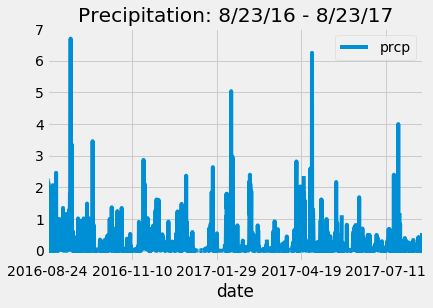

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_latest = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())
date_latest = list(np.ravel(date_latest))[0]
date_latest = dt.datetime.strptime(date_latest, '%Y-%m-%d')
# Calculate the date 1 year ago from the last data point in the database
year_latest = int(dt.datetime.strftime(date_latest, '%Y'))
month_latest = int(dt.datetime.strftime(date_latest, '%m'))
day_latest = int(dt.datetime.strftime(date_latest, '%d'))
# Perform a query to retrieve the data and precipitation scores
year_before = dt.date(year_latest, month_latest, day_latest) - dt.timedelta(days=365)

precip_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > year_before)
                  .order_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_table = pd.DataFrame(precip_data)
# Sort the dataframe by date

precip_table = precip_table.set_index('date')
precip_table = precip_table.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_table.plot(title="Precipitation: 8/23/16 - 8/23/17")


In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_table.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [30]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(f"Station Count: {stations}")

Station Count: 9


In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_count

station_ID = station_count[0][0]
station_name = (session.query(Station.name)
                      .filter_by(station = station_ID))
station_name = station_name[0][0]

print(f"The most active station is {station_ID}: {station_name}.")


The most active station is USC00519281: WAIHEE 837.5, HI US.


In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == station_ID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highest_temp = highest_temp[0]
print(f"The highest temperature is {highest_temp} degrees Farenheit.")

lowest_temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == station_ID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowest_temp = lowest_temp[0]
print(f"The lowest temperature is {lowest_temp} degrees Farenheit.")

avg_temp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == station_ID))
avg_temp = '{0:.3}'.format(avg_temp[0][0])
print(f"The average temperature is {avg_temp} degrees Farenheit.")

The highest temperature is 85.0 degrees Farenheit.
The lowest temperature is 54.0 degrees Farenheit.
The average temperature is 71.7 degrees Farenheit.


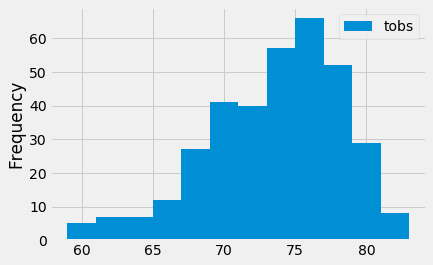

In [44]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > year_before)
                   .filter(Measurement.station == station_ID)
                   .order_by(Measurement.date)
                   .all())
temp_table = pd.DataFrame(temp_data)
temp_table = temp_table.set_index('date')
temp_table = temp_table.sort_index(ascending=True)
temp_table.plot(kind='hist', bins=12)

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax

temp_min = trip_temps[0][0]
temp_avg = trip_temps[0][1]
temp_max = trip_temps[0][2]

error_min = temp_avg - temp_min
error_max = temp_max - temp_avg

# for your trip using the previous year's data for those same dates.

trip = '2019-04-08 to \n 2019-04-19'
trip_start = '2017-04-08'
trip_end = '2017-04-19'

trip_temps = calc_temps(trip_start, trip_end)
trip_temps

[(67.0, 73.6, 83.0)]

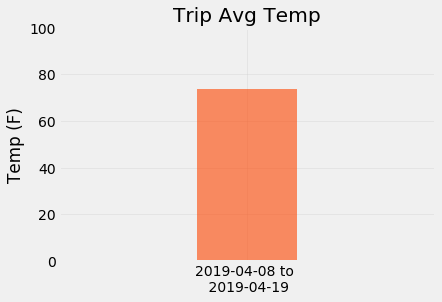

In [42]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(trip, temp_avg, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)


In [49]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
precip = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

precip_station = (session.query(*precip)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_start)
                   .filter(Measurement.date <= trip_end)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

precip_station

precip_table = pd.DataFrame(np.array(precip_station))

precip_table

,0,1,2,3,4,5
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.38,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",6.979999999999999,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.48,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.86,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.8099999999999999,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.31000000000000005,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


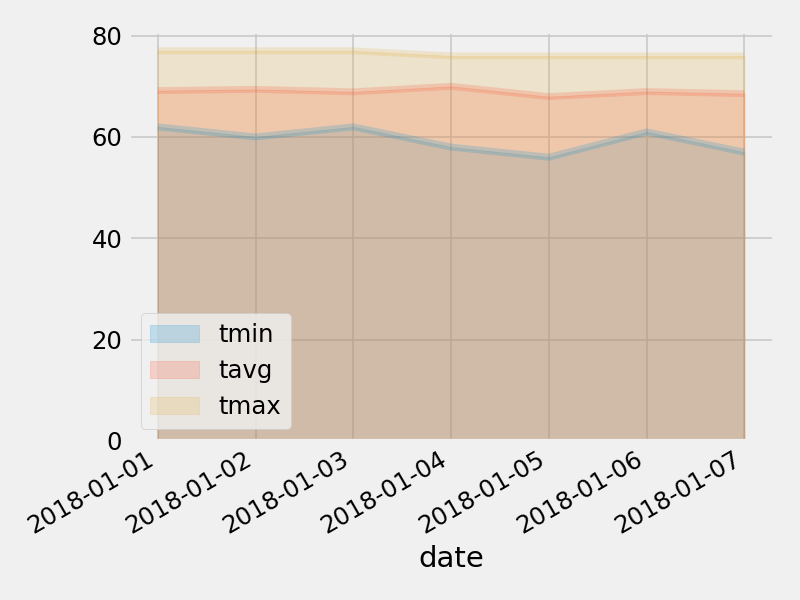

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
